# Environment and Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, r2_score

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [2]:
# Load data
data = pd.read_csv("/content/covid19.csv")

# EDA

In [3]:
# Info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 467 entries, 0 to 466
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CODE              467 non-null    object 
 1   POLITICS          467 non-null    object 
 2   POPULATION        387 non-null    float64
 3   AGE25_PROPTN      372 non-null    float64
 4   AGE_MEDIAN        207 non-null    float64
 5   AGE50_PROPTN      391 non-null    float64
 6   POP_DENSITY       368 non-null    float64
 7   GDP               363 non-null    float64
 8   INFANT_MORT       358 non-null    float64
 9   DOCS              376 non-null    float64
 10  VAX_RATE          391 non-null    float64
 11  HEALTHCARE_BASIS  463 non-null    object 
 12  HEALTHCARE_COST   370 non-null    float64
 13  DEATH_RATE        467 non-null    float64
 14  OBS_TYPE          467 non-null    object 
dtypes: float64(11), object(4)
memory usage: 54.9+ KB


In [4]:
# Describe
data.describe(include=["object", "float64"])

,CODE,POLITICS,POPULATION,AGE25_PROPTN,AGE_MEDIAN,AGE50_PROPTN,POP_DENSITY,GDP,INFANT_MORT,DOCS,VAX_RATE,HEALTHCARE_BASIS,HEALTHCARE_COST,DEATH_RATE,OBS_TYPE
count,467,467,387.000000,372.000000,207.000000,391.000000,368.000000,363.000000,358.000000,376.000000,391.000000,463,370.000000,467.000000,467
unique,467,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN,2
top,State467,UNSTABLE DEM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,INSURANCE,NaN,NaN,Train
freq,1,200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,274,NaN,NaN,328
mean,NaN,NaN,2901.225710,12.560255,33.883819,33.712718,498.381300,55.454758,14.102198,17.913681,39.811956,NaN,7567.429659,19.485729,NaN
std,NaN,NaN,1607.916659,15.622838,2.150579,26.664965,9.273898,7.079362,1.679505,24.002760,50.849504,NaN,4378.274723,5.950863,NaN
min,NaN,NaN,239.569188,-99.000000,28.523494,-99.000000,469.679414,14.917854,9.594397,-99.000000,-99.000000,NaN,4294.326253,4.035732,NaN
25%,NaN,NaN,1694.554946,13.106211,32.425808,37.038496,492.696217,53.795604,12.936613,20.758660,55.673757,NaN,4928.900712,15.502636,NaN
50%,NaN,NaN,2662.249643,14.519449,33.841647,38.831832,497.797964,56.463398,14.034245,22.691878,59.109108,NaN,5091.751888,19.761802,NaN
75%,NaN,NaN,3836.182945,16.350272,35.336905,40.519255,504.313718,58.874352,15.263909,24.363721,61.618239,NaN,14163.172358,22.878321,NaN


Outliers in VAX_RATE:
[ 11.         -99.          33.36982759  38.66409031  38.6044997
  33.59006798  39.13467658  34.64731867  32.84561522  39.56814163
  28.2680676   32.76723779  35.06119852  39.04531078]


<Axes: >

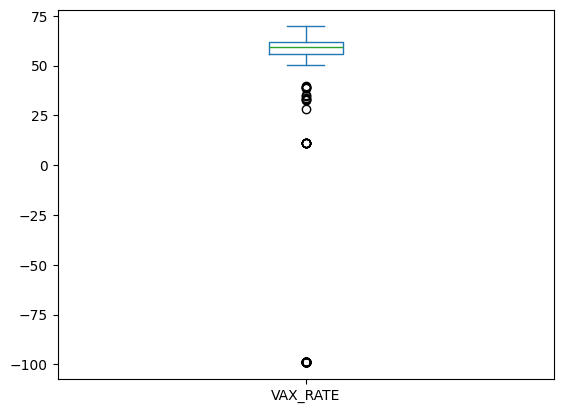

In [5]:
# EDA demo for numeric
Q1 = data["VAX_RATE"].quantile(0.25)
Q3 = data["VAX_RATE"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = data["VAX_RATE"][(data["VAX_RATE"] < lower_bound) | (data["VAX_RATE"] > upper_bound)]
print(f"Outliers in VAX_RATE:\n{outliers.unique()}")

data["VAX_RATE"].plot.box()

<Axes: ylabel='Frequency'>

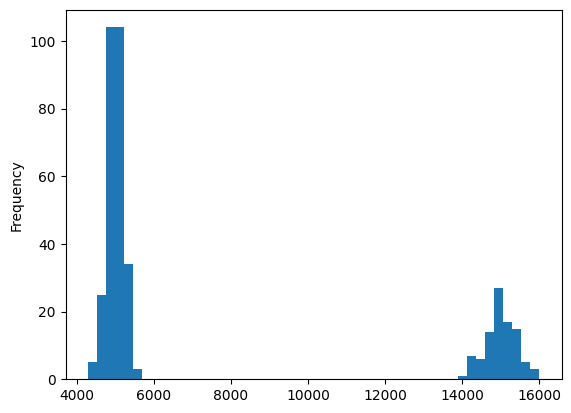

In [6]:
# EDA demo for bimodal distribution
data["HEALTHCARE_COST"].plot.hist(bins=50)

In [7]:
# EDA demo for categorical
data["POLITICS"].value_counts()

,count
POLITICS,
UNSTABLE DEM,200
STABLE DEM,182
DICTATORSHIP,38
OTHER,37
--,10


In [8]:
# Replace placeholders and outliers
data = data.replace([-99, "--"], np.nan)
data["VAX_RATE"] = data["VAX_RATE"].replace(11, np.nan)

<Axes: >

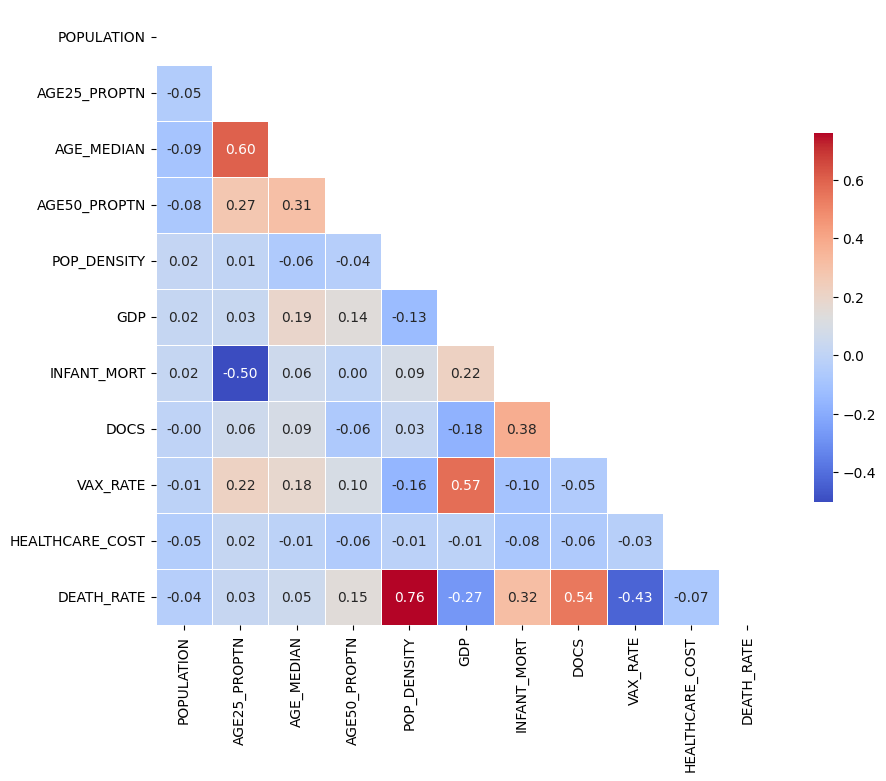

In [9]:
# Correlation plot
numeric_df = data.select_dtypes(include=np.number)
corr_matrix = numeric_df.corr()

plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f',
            cmap='coolwarm', linewidths=.5, cbar_kws={"shrink": .6} )

In [10]:
# Missing rate for each variable
data.isnull().sum() / len(data)

,0
CODE,0.000000
POLITICS,0.021413
POPULATION,0.171306
AGE25_PROPTN,0.218415
AGE_MEDIAN,0.556745
AGE50_PROPTN,0.194861
POP_DENSITY,0.211991
GDP,0.222698
INFANT_MORT,0.233405
DOCS,0.226981


# Pre-processing Pipeline

In [11]:
# Remove excessive missing variable
data = data.drop('AGE_MEDIAN', axis=1)

# Set CODE as index
data = data.set_index('CODE')

In [12]:
# Train Test Split
data_train = data[data["OBS_TYPE"] == "Train"].drop('OBS_TYPE', axis=1)
data_test = data[data["OBS_TYPE"] == "Test"].drop('OBS_TYPE', axis=1)

X_train = data_train.drop('DEATH_RATE', axis=1)
y_train = data_train["DEATH_RATE"]

X_test = data_test.drop('DEATH_RATE', axis=1)
y_test = data_test["DEATH_RATE"]

In [13]:
print(f"Train set shape:\n  X - {X_train.shape}, y - {y_train.shape}\nTest set shape:\n  X - {X_test.shape}, y - {y_test.shape}")

Train set shape:
  X - (328, 11), y - (328,)
Test set shape:
  X - (139, 11), y - (139,)


In [14]:
# Build pipeline to process numeric and categorical variables seperately
numeric_features = X_train.select_dtypes(include=np.number).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()

# Numeric: KNN imputation and scaling
numeric_transformer = Pipeline(steps=[('imputer', KNNImputer(n_neighbors=5)),
                                      ('scaler', StandardScaler()) ])

# Categorical: KNN imputation and encoding
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore')) ])

# Merge pipeline
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features),
                                               ('cat', categorical_transformer, categorical_features) ])

# Training

In [15]:
# Modelling with hyperparameter tuning using cross validation
model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('regressor', ElasticNet(max_iter=10000)) ])

# Define hyperparameter grid
param_grid = {'regressor__alpha': np.logspace(-4, 1, 20),
              'regressor__l1_ratio': [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1.0] }

# Cross validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Selecting best para using grid search
grid_search = GridSearchCV(model_pipeline, param_grid, cv=cv)

In [16]:
# Start training
grid_search.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          KNNImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['POPULATION',
                                                                          'AGE25_PROPTN',
                                                                          'AGE50_PROPTN',
                                                                          'POP_DENSITY',
                                                                          'GDP',
                                                                          'INFANT_MORT',
                                                                          'DOCS',
                                                                          'VAX_RATE',
                                                                          'HEALTHCARE_COST']),
                                                                        ('cat',
                                                                         Pipeline(ste...
             param_grid={'regressor__alpha': array([1.00000000e-04, 1.83298071e-04, 3.35981829e-04, 6.15848211e-04,
       1.12883789e-03, 2.06913808e-03, 3.79269019e-03, 6.95192796e-03,
       1.27427499e-02, 2.33572147e-02, 4.28133240e-02, 7.84759970e-02,
       1.43844989e-01, 2.63665090e-01, 4.83293024e-01, 8.85866790e-01,
       1.62377674e+00, 2.97635144e+00, 5.45559478e+00, 1.00000000e+01]),
                         'regressor__l1_ratio': [0.1, 0.5, 0.7, 0.9, 0.95, 0.99,
                                                 1.0]})

In [17]:
print(f"Best parameters found: {grid_search.best_params_}")

Best parameters found: {'regressor__alpha': np.float64(0.012742749857031334), 'regressor__l1_ratio': 1.0}


# Forecasting and Evaluation

In [18]:
# Predict on test
y_pred = grid_search.predict(X_test)

test_mse = mean_squared_error(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)
print(f"Test MSE: {test_mse:.4f}")
print(f"Test R2: {test_r2:.4f}")

Test MSE: 8.3958
Test R2: 0.8120
